In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1_F11.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_F11.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw10_F11/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv10_F11/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw10_F11/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n     k
0  0.99      0.98  0.99  0.82  0.95

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n     k
r2  0.99      0.98  0.99  0.82  0.95

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot    RmedianV       GSD         n         k
0        0.050777    0.752942  0.004014  0.193477  0.118257
1        1.797442  468.417486  0.123746  0.136558  0.086672
2        0.106240   11.433623  0.006803  0.417735  0.217260
3        1.634096   17.166460  0.054525  0.302061  0.038587
4       24.158845    4.474121  0.074385  0.093201  0.032173
...           ...         ...       ...       ...       ...
19464  113.372190    2.792440  0.035020  0.024091  0.029908
19465    0.018679    1.341632  0.014904  0.034869  0.121454
19466    0.381109    5.091681  0.011688  0.815302  0.095897
19467   13.473412    8.043168  0.001669  0.097557  0.040160
19468    2.692384    7.344087  0.085273  0.100967  0.013802

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    1.82     11.25  0.03  0.07  0.05
75%   17.47     63.13  0.06  0.14  0.12
90%   82.47    262.00  0.11  0.29  0.23
95%  173.32    455.23  0.14  0.45  0.32
99%  511.94    875.61  0.21  0.81  0.54

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot   RmedianV       GSD          n          k
0       1.025173   0.168406  0.237895   7.376774  15.679679
1      18.241615  15.861832  4.695567   6.540238   4.849067
2       0.383537   4.491037  0.651504  14.336948  19.729458
3       3.334106   3.304761  2.494783  12.777277   1.877087
4       5.472894   4.453142  3.373094   3.232082   1.622075
...          ...        ...       ...        ...        ...
19464   3.905495   1.140617  1.709338   1.651168   6.381179
19465   0.492430   0.656542  1.235322   2.232304  11.226585
19466   4.238931   0.964191  0.599463  30.314855   5.117292
19467   0.569204   1.031054  0.065297   3.475735   7.463655
19468   3.189966   4.355080  3.305306   3.938866   1.250116

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV    GSD      n       k
50%   3.01      2.23   1.30   3.09    5.05
75%   6.08      4.86   2.62   6.52   11.70
90%  12.24      9.64   4.35  13.28   25.43
95%  19.06     13.92   5.64  19.58   40.11
99%  33.61     23.25  11.58  31.38  153.46

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n     k
0  5.71      6.72  2.12  5.59  8.08

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD      n      k
r2               0.99      0.98  0.99   0.82   0.95
abs error 90%   82.47    262.00  0.11   0.29   0.23
abs error 95%  173.32    455.23  0.14   0.45   0.32
rel error 90%   12.24      9.64  4.35  13.28  25.43
rel error 95%   19.06     13.92  5.64  19.58  40.11
wmape            5.71      6.72  2.12   5.59   8.08

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

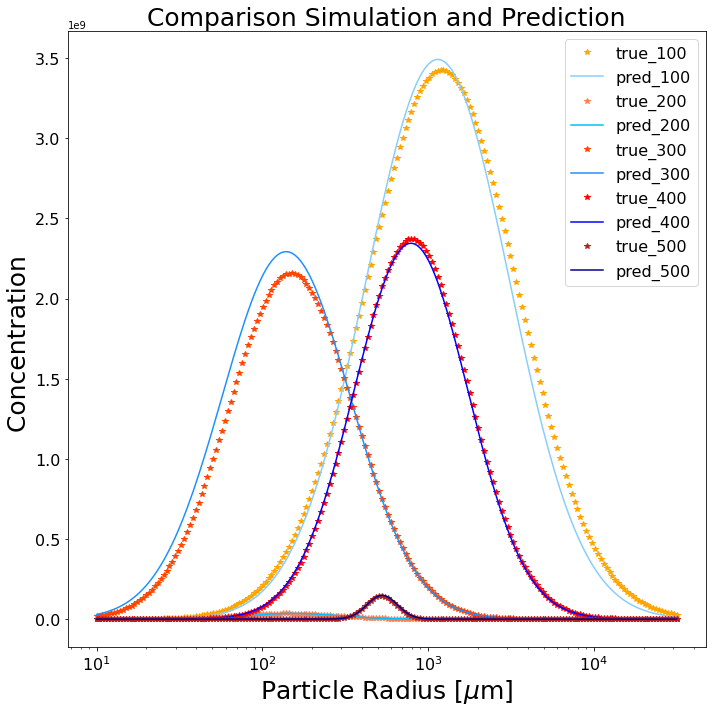

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

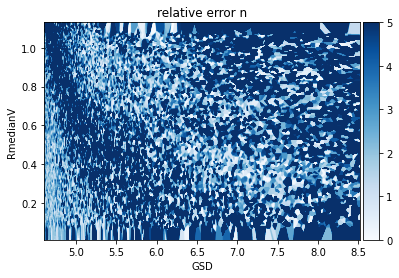

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

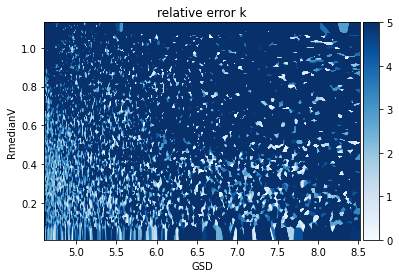

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

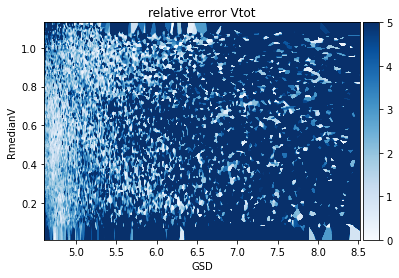

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  1.0 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0     1.0  ...      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   F11_168  F11_169  F11_170  
0      1.0      1.0      1.0  

[1 rows x 152 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11  PPF
r2  1.0  NaN

In [47]:
r2_adj_iv.values

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11     F11_12     F11_13     F11_14     F11_15  \
0        0.028241    0.118419   0.147293   0.120036   0.059863   0.039189   
1        0.095843    0.078326   0.060749   0.037644   0.020008   0.012677   
2        0.550597    1.752387   2.011390   1.223343   0.489953   0.359828   
3        0.493624    0.327899   0.271583   0.317166   0.187489   0.068213   
4        0.481635    0.593718   0.316513   0.391878   1.584589   4.157375   
...           ...         ...        ...        ...        ...        ...   
19464  137.698524  128.833890  92.597550  68.884727  71.339639  87.373180   
19465    0.342838    0.297321   0.300126   0.323830   0.308064   0.249211   
19466    0.644224    0.439844   0.409021   0.377815   0.311832   0.244784   
19467   23.042640   30.694037  40.139564  35.988539  25.256508  13.272888   
19468    0.030516    0.278187   0.776854   0.858656   0.557573   0.218288   

          F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0       0.058935   0.074709   0.068812   0.057435  ...  0.001626  0.001570   
1       0.012750   0.011897   0.009920   0.009325  ...  0.000346  0.000262   
2       0.268514   0.641606   1.353746   1.627516  ...  0.140320  0.138171   
3       0.025889   0.052762   0.021356   0.139662  ...  0.020298  0.018940   
4       3.963361   2.434329   0.827646   0.417506  ...  1.907012  2.186604   
...          ...        ...        ...        ...  ...       ...       ...   
19464  86.619583  67.424983  50.521928  37.365007  ...  0.823027  0.914854   
19465   0.205777   0.200932   0.202615   0.186141  ...  0.001110  0.000597   
19466   0.192230   0.172910   0.161350   0.154279  ...  0.000969  0.000704   
19467  11.365685  12.480535  12.480309  16.756543  ...  0.250086  0.432441   
19468   0.285333   0.481089   0.562264   0.784268  ...  0.048359  0.066601   

        F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0      0.001608  0.001485  0.001506  0.001482  0.001459  0.001550  0.001460   
1      0.000279  0.000283  0.000353  0.000499  0.000443  0.000451  0.000754   
2      0.134883  0.141030  0.135477  0.130142  0.126914  0.119485  0.114740   
3      0.020272  0.014371  0.018788  0.015805  0.017368  0.021786  0.018523   
4      2.469882  2.686595  2.620506  2.610523  2.364386  2.249234  2.086455   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.779691  0.923280  0.795097  0.730600  0.699352  0.598451  0.684623   
19465  0.000734  0.000292  0.000222  0.000227  0.000373  0.000813  0.001027   
19466  0.000697  0.000024  0.000016  0.000408  0.000645  0.000551  0.001192   
19467  0.437646  0.516301  0.569191  0.485758  0.491980  0.494589  0.505401   
19468  0.066431  0.085685  0.079424  0.074469  0.076428  0.062786  0.071880   

        F11_170  
0      0.001768  
1      0.000728  
2      0.106773  
3      0.025246  
4      1.779090  
...         ...  
19464  0.487329  
19465  0.001361  
19466  0.001011  
19467  0.362171  
19468  0.046058  

[19469 rows x 152 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    0.69    0.51    0.41    0.36    0.30    0.27    0.23    0.19    0.17   
75%    6.47    5.03    4.01    3.55    2.96    2.66    2.31    1.88    1.70   
90%   31.50   24.64   20.40   18.26   15.53   14.14   12.59   10.49    9.57   
95%   63.74   51.49   43.21   40.07   33.45   30.35   27.66   23.72   21.99   
99%  189.80  147.66  131.90  120.13  107.12   99.54   89.82   80.03   74.25   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.16  ...     0.01     0.01     0.01     0.01     0.01     0.01   
75%    1.51  ...     0.08     0.08     0.08     0.09     0.09     0.09   
90%    8.82  ...     0.47     0.51     0.51     0.55     0.56     0.57   
95%   20.31  ...     1.31     1.41     1.42     1.57     1.56     1.60   
99%   69.43  ...     5.90     6.11     6.28     6.67     6.92     7.35   

     F11_167  F11_168  F11_169  F11_170  
50%     0.01     0.01     0.01     0.01  
75%     0.09     0.09     0.10     0.09  
90%     0.57     0.58     0.63     0.60  
95%     1.61     1.61     1.73     1.73  
99%     8.01     8.32     9.08     9.53  

[5 rows x 152 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      0.141535  0.647655  0.881438  0.787638  0.431403  0.310543  0.513954   
1      1.192676  1.210436  1.149305  0.860893  0.546887  0.409894  0.483190   
2      0.536205  1.745701  2.054088  1.283496  0.529255  0.401062  0.309478   
3      0.281482  0.207675  0.190659  0.246279  0.160680  0.064379  0.026849   
4      0.050083  0.062966  0.034266  0.043345  0.179197  0.481000  0.469407   
...         ...       ...       ...       ...       ...       ...       ...   
19464  1.754604  1.735789  1.320886  1.041490  1.144199  1.487577  1.566299   
19465  2.855977  2.519556  2.591389  2.853472  2.774701  2.298004  1.945684   
19466  1.928576  1.466232  1.517347  1.558240  1.428092  1.243024  1.080663   
19467  0.361975  0.548408  0.811329  0.818890  0.644023  0.377691  0.359513   
19468  0.012946  0.123392  0.360286  0.416348  0.282624  0.115643  0.157949   

         F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163  \
0      0.717368  0.727700  0.668933  ...  0.812879  0.783247  0.800189   
1      0.523968  0.503722  0.542042  ...  0.313112  0.237263  0.252627   
2      0.766333  1.679234  2.101174  ...  8.987740  8.834529  8.601451   
3      0.059996  0.026569  0.189695  ...  0.518204  0.482486  0.515252   
4      0.295288  0.102869  0.053192  ...  0.947247  1.082539  1.218908   
...         ...       ...       ...  ...       ...       ...       ...   
19464  1.295410  1.031615  0.811030  ...  0.868371  0.964166  0.820758   
19465  1.951187  2.023812  1.915416  ...  0.430290  0.230555  0.282417   
19466  1.074297  1.105946  1.164463  ...  0.174466  0.126393  0.124934   
19467  0.437238  0.482608  0.712928  ...  0.269779  0.465078  0.469252   
19468  0.278190  0.339527  0.494394  ...  0.283088  0.388707  0.386588   

        F11_164   F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0      0.737740  0.746103  0.732813  0.719635  0.762377  0.716906  0.865828  
1      0.255860  0.319180  0.451174  0.399878  0.407442  0.680711  0.656777  
2      8.962786  8.575211  8.200405  7.958179  7.454359  7.121416  6.592976  
3      0.364414  0.475299  0.398896  0.437320  0.547257  0.464217  0.631307  
4      1.321839  1.285602  1.277204  1.153802  1.094962  1.013441  0.862361  
...         ...       ...       ...       ...       ...       ...       ...  
19464  0.970752  0.834971  0.766311  0.732657  0.626213  0.715564  0.508796  
19465  0.112077  0.084615  0.086254  0.141339  0.307573  0.387061  0.511703  
19466  0.004320  0.002902  0.072685  0.114600  0.097824  0.211059  0.178661  
19467  0.551928  0.606669  0.516245  0.521388  0.522733  0.532777  0.380854  
19468  0.497228  0.459648  0.429851  0.440064  0.360670  0.412007  0.263461  

[19469 rows x 152 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    0.70    0.60    0.55    0.54    0.51    0.51    0.49    0.47    0.47   
75%    1.32    1.12    1.01    0.97    0.94    0.93    0.91    0.87    0.86   
90%    2.16    1.84    1.66    1.56    1.55    1.58    1.54    1.49    1.47   
95%    2.98    2.52    2.29    2.17    2.14    2.23    2.19    2.14    2.14   
99%    6.65    5.43    4.98    4.61    4.87    4.58    4.84    4.73    4.60   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.46  ...     0.42     0.43     0.43     0.46     0.45     0.46   
75%    0.84  ...     0.77     0.78     0.78     0.83     0.83     0.83   
90%    1.42  ...     1.40     1.41     1.44     1.50     1.53     1.55   
95%    2.05  ...     2.16     2.23     2.29     2.42     2.47     2.52   
99%    4.53  ...     5.62     5.64     5.67     5.86     6.10     6.31   

     F11_167  F11_168  F11_169  F11_170  
50%     0.45     0.45     0.49     0.49  
75%     0.84     0.84     0.90     0.91  
90%     1.60     1.62     1.70     1.76  
95%     2.63     2.73     2.91     3.03  
99%     6.50     6.89     7.32     7.65  

[5 rows x 152 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      0.69
75%      6.47
90%     31.50
95%     63.74
99%    189.80
dtype: float64
Absolute error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error F11
50%    0.72
75%    1.32
90%    2.16
95%    3.03
99%    7.65
dtype: float64
Relative error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    0.94    0.83    0.79    0.78    0.74    0.75    0.73    0.69    0.68   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0    0.68  ...     0.78     0.81     0.83     0.89     0.92     0.96      1.0   

   F11_168  F11_169  F11_170  
0     1.04     1.14     1.17  

[1 rows x 152 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11  PPF
r2              1.00000  NaN
abs error 90%  31.50000  NaN
abs error 95%  63.74000  NaN
rel error 90%   2.16000  NaN
rel error 95%   3.03000  NaN
wmape           0.75863  NaN

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
    #pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    #meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    #axs[nr,1].set_ylabel('PPF [-]')
    #axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')